In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import glob
from PIL import Image

import matplotlib.pyplot as plt
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
train_df = pd.read_csv('training_set_pixel_size_and_HC.csv')

In [3]:
train_df.head()

,filename,pixel size,head circumference (mm)
0,1_HC.png,0.069136,44.30
1,2_HC.png,0.089659,56.81
2,3_HC.png,0.062033,68.75
3,4_HC.png,0.091291,69.00
4,5_HC.png,0.061240,59.81


In [4]:
train_df.shape

(999, 3)

In [5]:
train_img_names = train_df['filename'].values

In [6]:
val_img_names = train_img_names[799:]
train_img_names = train_img_names[:799]

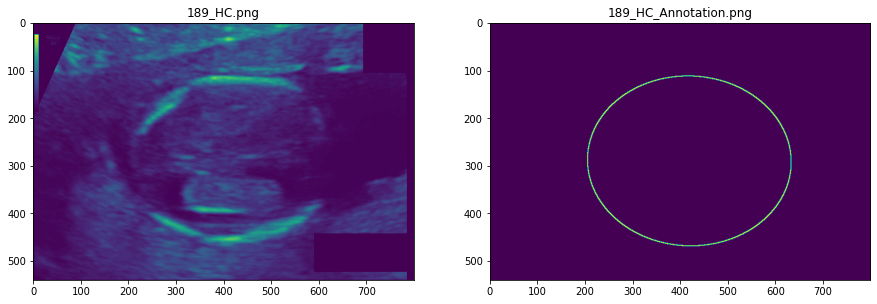

In [7]:
name = train_img_names[np.random.randint(0, train_img_names.shape[0] - 1)]
im1 = plt.imread("./Dataset/training_set/"+name)
im2 = plt.imread("./Dataset/training_set/"+name[0:len(name)-4]+"_Annotation.png")

plt.figure(figsize=(15, 15))
plt.subplot(1,2,1)
plt.title(name)
plt.imshow(im1)
plt.subplot(1,2,2)
plt.title(name[0:len(name)-4]+"_Annotation.png")
plt.imshow(im2)

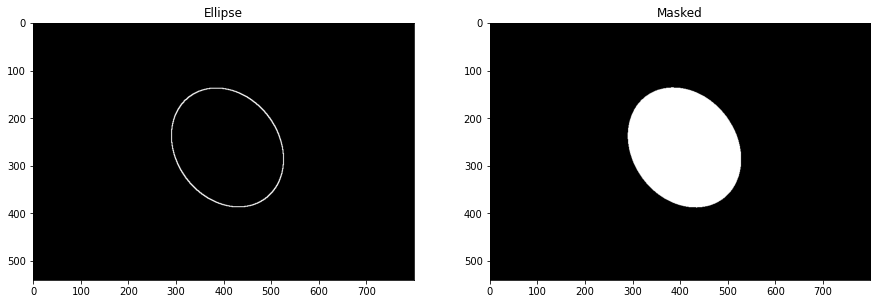

In [8]:
name = train_img_names[np.random.randint(0, train_img_names.shape[0] - 1)]
name = name[0:len(name) - 4]
image =  cv2.imread("./Dataset/training_set/"+name+"_Annotation.png",0)
im = image.copy()
im = cv2.cvtColor(im, cv2.COLOR_GRAY2BGR)

contours, hierarchy = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

for c in contours:
    ellipse = cv2.fitEllipse(c)
    cv2.ellipse(im, ellipse, (255,255,255), -1)

im1 = plt.imread("./Dataset/training_set/"+name+"_Annotation.png")
plt.figure(figsize=(15, 15))
plt.subplot(1,2,1)
plt.title("Ellipse")
plt.imshow(im1, cmap='gray')
plt.subplot(1,2,2)
plt.title("Masked")
plt.imshow(im)

In [9]:
for file_name in train_img_names:
    name = file_name[0:len(file_name)-4]

    image = cv2.imread("./Dataset/training_set/" + name + "_Annotation.png", 0)

    im = image.copy()
    im = cv2.cvtColor(im, cv2.COLOR_GRAY2BGR)

    contours, hierarchy = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    for c in contours:
        ellipse = cv2.fitEllipse(c)
        cv2.ellipse(im, ellipse, (255,255,255), -1)

    cv2.imwrite("./Dataset/train_masks/"+name+"_Annotation.png", im)

for file_name in val_img_names:
    name = file_name[0:len(file_name)-4]

    image = cv2.imread("./Dataset/val_set/" + name + "_Annotation.png", 0)

    im = image.copy()
    im = cv2.cvtColor(im, cv2.COLOR_GRAY2BGR)

    contours, hierarchy = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    for c in contours:
        ellipse = cv2.fitEllipse(c)
        cv2.ellipse(im, ellipse, (255,255,255), -1)

    cv2.imwrite("./Dataset/val_masks/"+name+"_Annotation.png", im)

### Defining the dataset class

In [10]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

In [11]:
x_size = (572, 572)
y_size = (572, 572)

In [12]:
class Data(torch.utils.data.Dataset):

    def __init__(self, data, transform=None):

        self.x_train = sorted(glob.glob('./Dataset/training_set/*HC.png'))
        self.y_train = sorted(glob.glob('./Dataset/training_set/*_Annotation.png'))
        self.x_val = sorted(glob.glob('./Dataset/val_set/*HC.png'))
        self.y_val = sorted(glob.glob('./Dataset/val_set/*_Annotation.png'))
        self.x_test = sorted(glob.glob('./Dataset/test_set/*HC.png'))

        self.data = data

    def __len__(self):

        if(self.data == 'train'):
            return len(self.x_train)

        elif(self.data == 'validate'):
            return len(self.x_val)

        elif(self.data == 'test'):
            return len(self.x_test)

        else:
            return ValueError("No data")


    def __getitem__(self, idx):

        if(self.data == 'train'):
            x = np.array(Image.open(self.x_train[idx]).convert("L").resize(x_size)).reshape(1, 572, 572)
            y = np.array(Image.open(self.y_train[idx]).convert("L").resize(y_size)).reshape(1, 572, 572) # Convert to gray scale
            return torch.from_numpy(x).float().to(device), torch.from_numpy(y).float().to(device)

        elif(self.data == 'validate'):
            x = np.array(Image.open(self.x_val[idx]).convert("L").resize(x_size)).reshape(1, 572, 572)
            y = np.array(Image.open(self.y_val[idx]).convert("L").resize(y_size)).reshape(1, 572, 572) # Convert to gray scale
            return torch.from_numpy(x).float().to(device), torch.from_numpy(y).float().to(device)

        elif(self.data == 'test'):
            x = np.array(Image.open(self.x_test[idx]).convert("L").resize(x_size)).reshape(1, 572, 572)
            y = np.array(Image.open(self.y_test[idx]).convert("L").resize(y_size)).reshape(1, 572, 572) # Convert to gray scale
            return torch.from_numpy(x).float().to(device), torch.from_numpy(y).float().to(device)

        else:
            return ValueError("No data")


### Defining the UNet model

In [13]:
class res_conv(nn.Module):

    def __init__(self, input_channels, output_channels, down=True):
        super(res_conv, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1),
                                   nn.BatchNorm2d(output_channels),
                                   nn.ReLU(inplace = True),
                                   nn.Dropout(0.5),
                                 )
        self.conv2 = nn.Sequential(nn.Conv2d(output_channels, output_channels, kernel_size=3, padding=1),
                                   nn.BatchNorm2d(output_channels),
                                   nn.ReLU(inplace = True),
                                   nn.Dropout(0.5),
                                  )

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)+x1
        return x2


class start_conv(nn.Module):

    def __init__(self, input_channels, output_channels):
        super(start_conv, self).__init__()
        self.conv = res_conv(input_channels, output_channels)

    def forward(self, x):
        x = self.conv(x)
        return x


class down_conv(nn.Module):

    def __init__(self, input_channels, output_channels):
        super(down_conv, self).__init__()
        self.conv = nn.Sequential(nn.MaxPool2d(2),
                                  res_conv(input_channels, output_channels),
                                 )

    def forward(self,x):
        x = self.conv(x)
        return x



class up_conv(nn.Module):

    def __init__(self, input_channels, output_channels):
        super(up_conv, self).__init__()
        self.up = nn.ConvTranspose2d(input_channels//2, input_channels//2, kernel_size=2, stride=2)
        self.conv = res_conv(input_channels, output_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diff1 = x2.shape[2]-x1.shape[2]
        diff2 = x2.shape[3]-x1.shape[3]
        x1 = F.pad(x1, pad=(diff1//2, diff1-diff1//2, diff2//2, diff2-diff2//2))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class stop_conv(nn.Module):

    def __init__(self, input_channels, output_channels):
        super(stop_conv, self).__init__()
        self.conv = nn.Sequential(nn.Conv2d(input_channels, output_channels, kernel_size=1),
                                 nn.Sigmoid())


    def forward(self, x):
        x = self.conv(x)
        return x

class Unet(nn.Module):
    def __init__(self):
        super(Unet, self).__init__()

        self.inc = start_conv(1, 64)
        self.down1 = down_conv(64, 128)
        self.down2 = down_conv(128, 256)
        self.down3 = down_conv(256, 512)
        self.down4 = down_conv(512, 512)
        self.up1 = up_conv(1024, 256)
        self.up2 = up_conv(512, 128)
        self.up3 = up_conv(256, 64)
        self.up4 = up_conv(128, 64)
        self.outc = stop_conv(64, 1)

    def forward(self, x):

        xin = self.inc(x)
        xd1 = self.down1(xin)
        xd2 = self.down2(xd1)
        xd3 = self.down3(xd2)
        xd4 = self.down4(xd3)
        xu1 = self.up1(xd4, xd3)
        xu2 = self.up2(xu1, xd2)
        xu3 = self.up3(xu2, xd1)
        xu4 = self.up4(xu3, xin)
        xout = self.outc(xu4)
        return xout


### Training the UNet model

In [14]:
num_epochs = 1
batch_size = 2

In [15]:
# Defining the loss as the dice coefficient

def dice_sim(pred, truth):
    epsilon = 1e-8
    num_batches = pred.size(0)
    m1 = pred.view(num_batches, -1).bool()
    m2 = truth.view(num_batches, -1).bool()

    intersection = torch.logical_and(m1, m2).sum(dim=1)
    return (((2. * intersection + epsilon) / (m1.sum(dim=1) + m2.sum(dim=1) + epsilon)).sum(dim=0))/2

In [16]:
train = Data('train', None)
val = Data('validate', None)
test = Data('test', None)

In [17]:
train_generator = DataLoader(train, batch_size=2, shuffle=True, num_workers=0)
val_generator = DataLoader(val, batch_size=2, shuffle=True, num_workers=0)
test_generator = DataLoader(test, batch_size=2, shuffle=True, num_workers=0)

In [18]:
model = Unet().to(device)

In [19]:
loss_fn = nn.BCELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4, min_lr=1e-9)
train_size = len(train)
val_size = len(val)

In [20]:
for epoch in range(num_epochs):

    running_loss = 0.0
    val_loss = 0.0
    val_acc = 0.0

    # Training
    for i, data in enumerate(train_generator):
        image, truth = data
        truth = truth/255
        predictions = model(image)
        loss = loss_fn(predictions, truth)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    # Validation
    with torch.no_grad():
        for i, data in enumerate(val_generator):
            image, truth = data
            truth = truth/255
            predictions = model(image)
            predictions = torch.round(predictions) # Rounding the predictions for classification
            loss = loss_fn(predictions, truth)
            val_loss += loss.item()
            val_acc += dice_sim(predictions, truth)*100

    epoch_train_loss = running_loss / (train_size//batch_size+1)
    epoch_val_loss = val_loss / (val_size//batch_size+1)
    epoch_val_acc = val_acc / (val_size//batch_size+1)
    scheduler.step(epoch_val_loss) # LR Scheduler
    print(f"==>train_loss: {epoch_train_loss} ==>val_loss: {epoch_val_loss} ==>val_accuracy: {epoch_val_acc}")